In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Cargamos las librerías necesarias
import math
from functools import reduce

import pandas as pd
import numpy as np
from pygam import GAM, te, f, s, te
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
import shap

from src.visualization.metrics_summary import cross_val_reg, gam_cross_val_reg, err_hist, pred_hist, plot_residuo, plot_corr_matrix

/home/vacek/anaconda3/envs/descansare/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/vacek/anaconda3/envs/descansare/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Leemos los datos
perfiles_sqr = pd.read_parquet('../data/processed/perfiles_sqr_knn.parquet')

# Lateral = 0, Supine = 1
# Male = 1, Female = 0

In [4]:
X = perfiles_sqr[['posicion', 'sexo', 'presiones', 'altura', 'peso']]
y = perfiles_sqr['sqr']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
describe_presiones = perfiles_sqr.loc[X_train.index].groupby('presiones').describe()

In [7]:
describe_presiones

altura                                                            \
           count        mean        std    min    25%    50%    75%    max   
presiones                                                                    
000000     357.0  171.299720   5.618221  150.0  168.0  170.0  176.0  185.0   
000001       3.0  178.000000   0.000000  178.0  178.0  178.0  178.0  178.0   
000002       9.0  168.000000   0.000000  168.0  168.0  168.0  168.0  168.0   
000321      38.0  167.000000   0.000000  167.0  167.0  167.0  167.0  167.0   
000333       7.0  180.000000   0.000000  180.0  180.0  180.0  180.0  180.0   
...          ...         ...        ...    ...    ...    ...    ...    ...   
543455      42.0  178.000000   0.000000  178.0  178.0  178.0  178.0  178.0   
555443       3.0  176.000000   0.000000  176.0  176.0  176.0  176.0  176.0   
555532       8.0  174.000000   0.000000  174.0  174.0  174.0  174.0  174.0   
555554      15.0  160.000000   0.000000  160.0  160.0  160.0  160.0  160.0   
555555     313.0  171.533546  10.107419  150.0  165.0  170.0  179.0  188.0   

            peso             ... posicion        sexo                      \
           count       mean  ...      75%  max  count      mean       std   
presiones                    ...                                            
000000     357.0  80.798319  ...      1.0  1.0  357.0  0.633053  0.482648   
000001       3.0  81.000000  ...      0.0  0.0    3.0  0.000000  0.000000   
000002       9.0  54.000000  ...      1.0  1.0    9.0  0.000000  0.000000   
000321      38.0  69.000000  ...      0.0  0.0   38.0  0.000000  0.000000   
000333       7.0  95.000000  ...      1.0  1.0    7.0  1.000000  0.000000   
...          ...        ...  ...      ...  ...    ...       ...       ...   
543455      42.0  76.000000  ...      1.0  1.0   42.0  1.000000  0.000000   
555443       3.0  81.000000  ...      0.0  0.0    3.0  1.000000  0.000000   
555532       8.0  82.000000  ...      0.0  0.0    8.0  1.000000  0.000000   
555554      15.0  85.000000  ...      0.0  0.0   15.0  0.000000  0.000000   
555555     313.0  77.664537  ...      1.0  1.0  313.0  0.571885  0.495598   

                                    
           min  25%  50%  75%  max  
presiones                           
000000     0.0  0.0  1.0  1.0  1.0  
000001     0.0  0.0  0.0  0.0  0.0  
000002     0.0  0.0  0.0  0.0  0.0  
000321     0.0  0.0  0.0  0.0  0.0  
000333     1.0  1.0  1.0  1.0  1.0  
...        ...  ...  ...  ...  ...  
543455     1.0  1.0  1.0  1.0  1.0  
555443     1.0  1.0  1.0  1.0  1.0  
555532     1.0  1.0  1.0  1.0  1.0  
555554     0.0  0.0  0.0  0.0  0.0  
555555     0.0  0.0  1.0  1.0  1.0  

[136 rows x 40 columns]

In [8]:
sqr_presiones = describe_presiones.loc[:, 'sqr']

In [9]:
sqr_presiones

,count,mean,std,min,25%,50%,75%,max
presiones,,,,,,,,
000000,357.0,72.642562,16.006749,2.769516,64.454420,75.551681,83.607054,99.350000
000001,3.0,74.254890,4.449736,70.387602,71.823211,73.258820,76.188533,79.118246
000002,9.0,87.900198,4.372958,83.158636,85.182526,87.735229,88.811504,96.157703
000321,38.0,82.093909,10.444351,60.886760,73.211493,81.072529,92.641328,97.356944
000333,7.0,80.263614,4.208739,72.065380,79.457860,79.589220,83.436795,84.401389
...,...,...,...,...,...,...,...,...
543455,42.0,75.626641,11.161955,34.909822,69.268559,78.016708,82.866367,93.049619
555443,3.0,64.675855,16.740325,47.636321,56.463782,65.291243,73.195622,81.100000
555532,8.0,76.203737,14.906466,45.220459,74.864905,76.883803,79.842474,99.016915


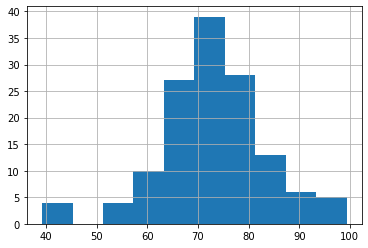

In [10]:
sqr_presiones['mean'].hist();

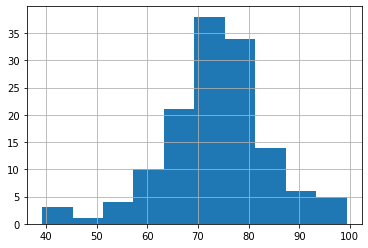

In [11]:
sqr_presiones['50%'].hist();

In [12]:
sqr_presiones['50%'].describe()

count    136.000000
mean      73.640673
std       10.759416
min       39.203386
25%       68.066502
50%       73.952140
75%       79.939194
max       99.341667
Name: 50%, dtype: float64

In [16]:
[i for i in sqr_presiones.index if sqr_presiones.loc[i, '50%'] < 68.066502]

['002211',
 '010002',
 '011122',
 '012321',
 '012332',
 '021112',
 '022333',
 '022421',
 '023421',
 '030111',
 '042045',
 '042233',
 '101220',
 '102012',
 '111111',
 '112233',
 '123211',
 '123222',
 '123343',
 '133301',
 '133331',
 '133431',
 '135321',
 '144332',
 '233332',
 '233343',
 '233443',
 '334443',
 '335532',
 '423330',
 '525332',
 '534451',
 '555443',
 '555554']

In [17]:
[i for i in sqr_presiones.index if 68.182906 <= sqr_presiones.loc[i, '50%'] <= 79.939194]

['000000',
 '000001',
 '000333',
 '010001',
 '010010',
 '010022',
 '012211',
 '012221',
 '012222',
 '012232',
 '022110',
 '022111',
 '022211',
 '022212',
 '022221',
 '022222',
 '022320',
 '022321',
 '022332',
 '023211',
 '023321',
 '023332',
 '033211',
 '033212',
 '033330',
 '033333',
 '040034',
 '101111',
 '110012',
 '110302',
 '112321',
 '113333',
 '122211',
 '122212',
 '122221',
 '122222',
 '122232',
 '122321',
 '122322',
 '122332',
 '123321',
 '123322',
 '123332',
 '123333',
 '132332',
 '133432',
 '134312',
 '222222',
 '223333',
 '233333',
 '233432',
 '234432',
 '234443',
 '234453',
 '234532',
 '333333',
 '334444',
 '335541',
 '355544',
 '432221',
 '435533',
 '444453',
 '455554',
 '543455',
 '555532',
 '555555']

In [18]:
[i for i in sqr_presiones.index if sqr_presiones.loc[i, '50%'] > 79.939194]

['000002',
 '000321',
 '001310',
 '003333',
 '011000',
 '011100',
 '011111',
 '022311',
 '023111',
 '023112',
 '023212',
 '023322',
 '032325',
 '033321',
 '043311',
 '112221',
 '112232',
 '123212',
 '123312',
 '123331',
 '123421',
 '133321',
 '133332',
 '222000',
 '223332',
 '223344',
 '233321',
 '233433',
 '234323',
 '343333',
 '344333',
 '355345',
 '423334',
 '444444']